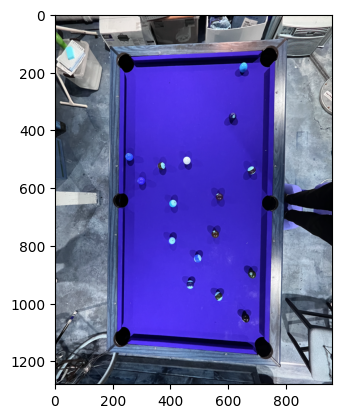

In [17]:
#import cv2, numpy and matplotlib libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
  
x1='images/all_balls/1280x1280/IMG_2735.png'
grayscale = cv2.imread(x1, 0)
image1 = cv2.imread(x1,1)

plt.imshow(image1)
plt.show() 
  

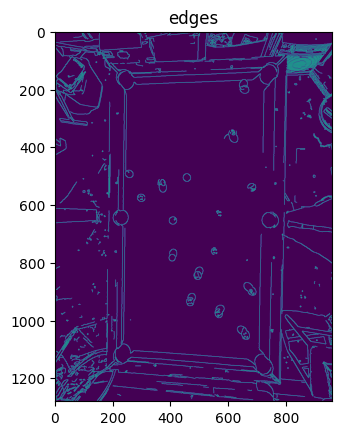

In [18]:
img_blur = cv2.GaussianBlur(grayscale, (3,3), 0) 
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
plt.title('edges')
plt.imshow(edges)
plt.show()

Limit the image to only the pool table. Credit to Ben.
Perhaps could optimize to use a histogram to progamatically get the color of the felt

In [19]:
# order is blue, green, red
lower_blue = np.array([0,0,150])
upper_blue = np.array([150,100,255])
# Threshold the HSV image to get only blue colors
mask = cv2.inRange(image1, lower_blue, upper_blue)
erosion = mask
kernel = np.ones((7,7),np.uint8)
dilation = cv2.dilate(erosion, kernel, iterations = 4)

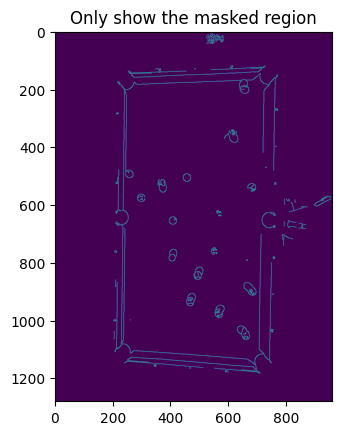

In [20]:
res = cv2.bitwise_and(edges, dilation)
plt.title('Only show the masked region')
plt.imshow(res)
plt.show()

722.8898835997768 12.618089756421552
(696, 1512) (749, -1487)
6.735602284241807 192.8824296349165
(-1492, 245) (1505, 140)
246.96238070421145 4.310744356619811
(220, 1504) (273, -1495)
-95.69703427336117 1093.821775990624
(-1589, 963) (1398, 1224)
253.9613145703227 4.432911200734543
(227, 1504) (280, -1495)
762.8837914061269 13.316186008505731
(736, 1513) (789, -1486)
8.478427718253645 161.77798448313771
(-1489, 240) (1506, 83)
759.8842483206506 13.263828789599419
(733, 1513) (786, -1486)


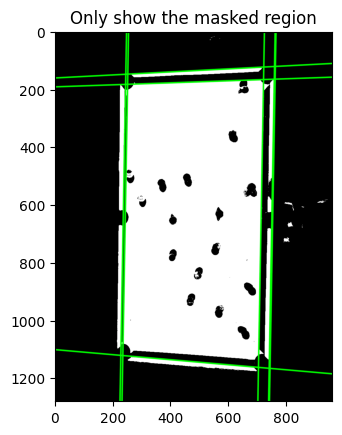

In [24]:

import math

msk_lines = np.zeros((1280, 1280,3), dtype=np.uint8)
img_lines = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
lines = cv2.HoughLines(res,1,np.pi/180,190,None,0,0)
if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            print(x0, y0)
            pt1 = (int(x0 + 1500*(-b)), int(y0 + 1500*(a)))
            pt2 = (int(x0 - 1500*(-b)), int(y0 - 1500*(a)))
            print (pt1, pt2)
            cv2.line(msk_lines, pt1, pt2, (0,255,0), 3, cv2.LINE_AA)
            cv2.line(img_lines, pt1, pt2, (0,255,0), 3, cv2.LINE_AA)

plt.title('Only show the masked region')
plt.imshow(img_lines)
plt.show()

https://www.geeksforgeeks.org/python-corner-detection-with-shi-tomasi-corner-detection-method-using-opencv/?ref=rp
Shi-Thomas Corner Detection

(254, 180)
(237, 1126)
(716, 171)
(699, 1159)


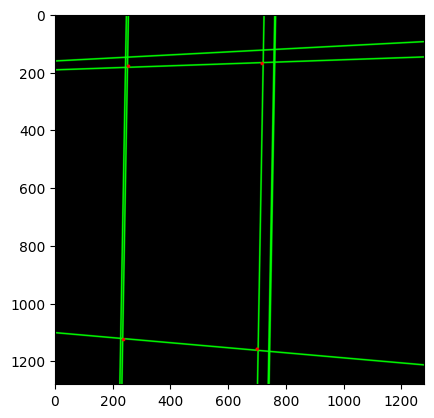

In [25]:
gry_msk_lines = cv2.cvtColor(msk_lines, cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gry_msk_lines, 100, 0.01, 10)
msk_lines_out = msk_lines.copy()

corners = np.intp(corners)
h,w, = msk_lines_out.shape[:2]
c1 = [0, 0]
c2 = [0, w]
c3 = [h, 0]
c4 = [h, w]

center = [h/2, w/2]

table_c_dist1 = math.dist(c1, center)
table_c_dist2 = math.dist(c2, center)
table_c_dist3 = math.dist(c3, center)
table_c_dist4 = math.dist(c4, center)

table_cornerUL = c1
table_cornerLL = c2
table_cornerUR = c3
table_cornerLR = c4

for i in corners:
    x, y = i.ravel()
    euc_1 = math.dist(c1,[x,y])
    euc_2 = math.dist(c2,[x,y])
    euc_3 = math.dist(c3,[x,y])
    euc_4 = math.dist(c4,[x,y])

    dist = [euc_1, euc_2, euc_3, euc_4]
    min_euc = min(dist)

    if euc_1 == min_euc:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist1:
            table_c_dist1 = euc_cen
            table_cornerUL = (x,y)
    elif euc_2 ==  min_euc:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist2:
            table_c_dist2 = euc_cen
            table_cornerLL = (x,y)    
    elif euc_3 ==  min_euc:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist3:
            table_c_dist3 = euc_cen
            table_cornerUR = (x,y) 
    else:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist4:
            table_c_dist4 = euc_cen
            table_cornerLR = (x,y) 
    # find which quadrant
    # draw red color circles on all corners
print(table_cornerUL)
print(table_cornerLL)
print(table_cornerUR)
print(table_cornerLR)

cv2.circle(msk_lines_out, table_cornerUL, 6, (255, 0, 0), -1)
cv2.circle(msk_lines_out, table_cornerLL, 6, (255, 0, 0), -1)
cv2.circle(msk_lines_out, table_cornerUR, 6, (255, 0, 0), -1)
cv2.circle(msk_lines_out, table_cornerLR, 6, (255, 0, 0), -1)

# resulting image
plt.imshow(msk_lines_out)


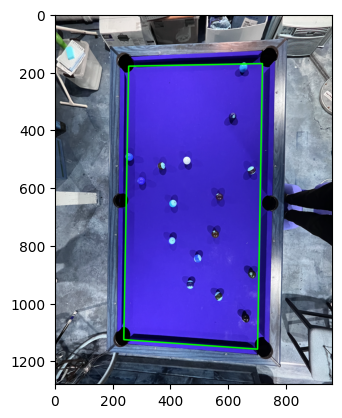

In [26]:
img_draw_box = image1.copy()


cv2.line(img_draw_box, table_cornerUL, table_cornerUR, (0,255,0), 3, cv2.LINE_AA)
cv2.line(img_draw_box, table_cornerUR, table_cornerLR, (0,255,0), 3, cv2.LINE_AA)
cv2.line(img_draw_box, table_cornerLR, table_cornerLL, (0,255,0), 3, cv2.LINE_AA)
cv2.line(img_draw_box, table_cornerLL, table_cornerUL, (0,255,0), 3, cv2.LINE_AA)

plt.imshow(img_draw_box)

https://theailearner.com/tag/cv2-getperspectivetransform/

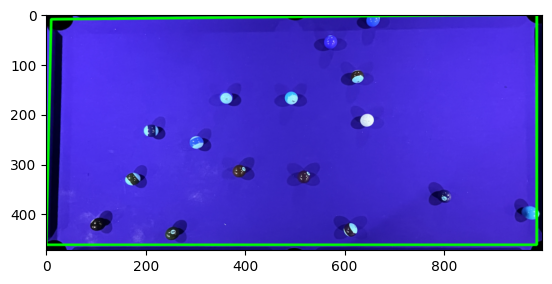

In [41]:
src_cor = np.float32([table_cornerLL, table_cornerLR, table_cornerUR, table_cornerUL])
width_1 = math.dist(table_cornerLL, table_cornerUL)
width_2 = math.dist(table_cornerLR, table_cornerUR)
max_width = max(int(width_1), int(width_2))

height_1 = math.dist(table_cornerLL, table_cornerLR)
height_2 = math.dist(table_cornerUL, table_cornerUR)
max_height = max(int(height_1), int(height_2))
dst_cor = np.float32([[10, 10],
                        [0, max_height - 1],
                        [max_width - 1, max_height - 1],
                        [max_width - 1, 10]])

M = cv2.getPerspectiveTransform(src_cor, dst_cor)
rotated_table = cv2.warpPerspective(img_draw_box,M,(max_width+10, max_height+10),flags=cv2.INTER_LINEAR)

plt.imshow(rotated_table)